<a href="https://colab.research.google.com/github/btlgs2000/Elettric80/blob/main/NN_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import random

In [ ]:
train_data = np.loadtxt("mnist_train.csv", 
                        delimiter=",")
test_data = np.loadtxt("mnist_test.csv", 
                       delimiter=",")

In [ ]:
train_data.shape

(60000, 785)

In [ ]:
def to_one_hot(n):
    one_hot = [0]*10
    one_hot[n] = 1
    return one_hot

In [ ]:
test_labels = test_data[:, 0].astype(int)
test_labels_one_hot = np.asarray([to_one_hot(int(x.tolist())) for x in test_labels])
test_images = test_data[:, 1:].reshape(-1, 28,28) / 255.
train_labels = train_data[:, 0].astype(int)
train_labels_one_hot = np.asarray([to_one_hot(int(x.tolist())) for x in train_labels])
train_images = train_data[:, 1:].reshape(-1, 28,28) / 255.

In [ ]:
train_images.shape

(60000, 28, 28)

In [ ]:
class LinearLayer:
    def __init__(self, in_n, out_n, init="kaiming", sigma=1):
        self.in_n = in_n
        self.out_n = out_n
        # Kaiming inizialization
        self.b = np.zeros((1, out_n))
        if init == "kaiming":
            self.W = np.random.randn(in_n, out_n) * np.sqrt(2/in_n)
        else:
            self.W = np.random.randn(in_n, out_n) * sigma
    
    def forward(self, x):
        self.minibatch_n = x.shape[0]
        # dim x = minibatch_n x in_n
        self.x = x
        # minibatch_n x out_n
        y = np.matmul(x, self.W) + self.b # broadcasting su b
        return y
        
    def backward(self, dy):          
        # dim dy = minibatch_n x out_n
        # minibatch_n x in_n
        dx = np.matmul(dy, self.W.T)
        # minibatch_n x out_n
        self.db = dy
        self.db = np.sum(self.db, axis=0)
        # minibatch_n x in_n x out_n
        self.dW = np.matmul(self.x.reshape(self.minibatch_n, self.in_n, 1), dy.reshape(self.minibatch_n, 1, self.out_n))
        self.dW = np.sum(self.dW, axis=0)
        return dx

In [ ]:
class ReLU:
    def forward(self, x):
        self.mask = x > 0
        return np.maximum(x, 0)
    
    def backward(self, dy):
        return np.multiply(dy, self.mask)

In [ ]:
class Sigmoid:
    def forward(self, x):
        self.sigma = 1/(1+np.exp(-x))
        return self.sigma
    
    def backward(self, dy):
        return np.multiply(dy, np.multiply(self.sigma, 1 - self.sigma))

In [ ]:
class Tanh:
    def forward(self, x):
        self.tanh = np.tanh(x)
        return self.tanh
    
    def backward(self, dy):
        return np.multiply(dy, 1 - self.tanh**2)

In [ ]:
class Identity:
    def forward(self, x):
        return x
    
    def backward(self, dy):
        return dy

In [ ]:
class Softmax:
    def forward(self, x):
        # dim x = batch x n
        M = np.amax(x, axis=1, keepdims=True)
        # per evitare overflow
        # batch x n
        self.expx = np.exp(np.subtract(x, M))
        # batch x 1
        self.expsums = np.sum(self.expx, axis=1, keepdims=True)
        return np.divide(self.expx, self.expsums)
        
    def backward(self, dy):
        # dim dy = batch x n
        # dx = np.zeros_like(dy)
        b, n = dy.shape
        expnorm = self.expx/self.expsums
        J = -expnorm.reshape(b,n,1)@expnorm.reshape(b,1,n) + expnorm.reshape(b,1,n)*np.identity(n).reshape(1,n,n)
        # batch x n
        dx = np.matmul(dy.reshape(b, 1, n), J).reshape(b, n)
        return dx

In [ ]:
class CrossEntropyLoss:
    def forward(self, y, y_):
        # y sono le vere label
        # y_ sono le label predette
        # dim y : b x n
        self.b = y.shape[0]
        return - (y*np.log(y_)).sum()/self.b
        
    def backward(self, y, y_):
        # b x n
        dy_ = -1/self.b * y/y_
        return dy_

In [ ]:
class FullyConnectedNN:
    def __init__(self, layers_n, activation="ReLU", init="kaiming", sigma=1):
        self.activations_dict = {"ReLU" : ReLU, "Tanh" : Tanh, "Sigmoid" : Sigmoid, "Identity" : Identity}
        self.layers_n = layers_n
        self.N = len(layers_n) - 1
        self.linear_layers = [LinearLayer(layers_n[i], layers_n[i+1], init, sigma) for i in range(self.N)]
        self.activations = [self.activations_dict[activation]() for i in range(self.N-1)]
        self.softmax = Softmax()
        self.loss = CrossEntropyLoss()
        
    def forward(self, x, y):
        for i in range(self.N-1):
            x = self.linear_layers[i].forward(x)
            x = self.activations[i].forward(x)
        y_ = self.linear_layers[self.N-1].forward(x)
        y_ = self.softmax.forward(y_)
        loss = self.loss.forward(y, y_)
        return y_, loss

    def backward(self, y, y_):
        dj = self.loss.backward(y, y_)
        dj = self.softmax.backward(dj)
        linear_layer = self.linear_layers[-1]
        dj = linear_layer.backward(dj)
        for linear_layer, activation in zip(list(reversed(self.linear_layers))[1:], reversed(self.activations)):
            dj = activation.backward(dj)
            dj = linear_layer.backward(dj)
            
    def gradient_descent_step(self, alpha):
        for linear_layer in self.linear_layers:
            linear_layer.W -= alpha*linear_layer.dW
            linear_layer.b -= alpha*linear_layer.db

In [ ]:
nn = FullyConnectedNN([28*28, 100, 100, 100, 10], activation="ReLU", init="kaiming", sigma=1)

In [ ]:
def get_random_patch(x, y, n):
    idx = np.asarray(random.sample(range(x.shape[0]), n))
    return x[idx], y[idx]

In [ ]:
def get_accuracy(y, y_):
    y__ = np.zeros_like(y_)
    y__[np.arange(y_.shape[0]), np.argmax(y_, axis=1)] = 1
    ret = np.all(y == y__, axis=1)
    return ret.sum()/ret.shape[0]

In [ ]:
train_losses = []
test_losses = []
accuracies = []

In [ ]:
NUM_EPOCHS = 1
ALPHA = 0.05

<IPython.core.display.Javascript object>


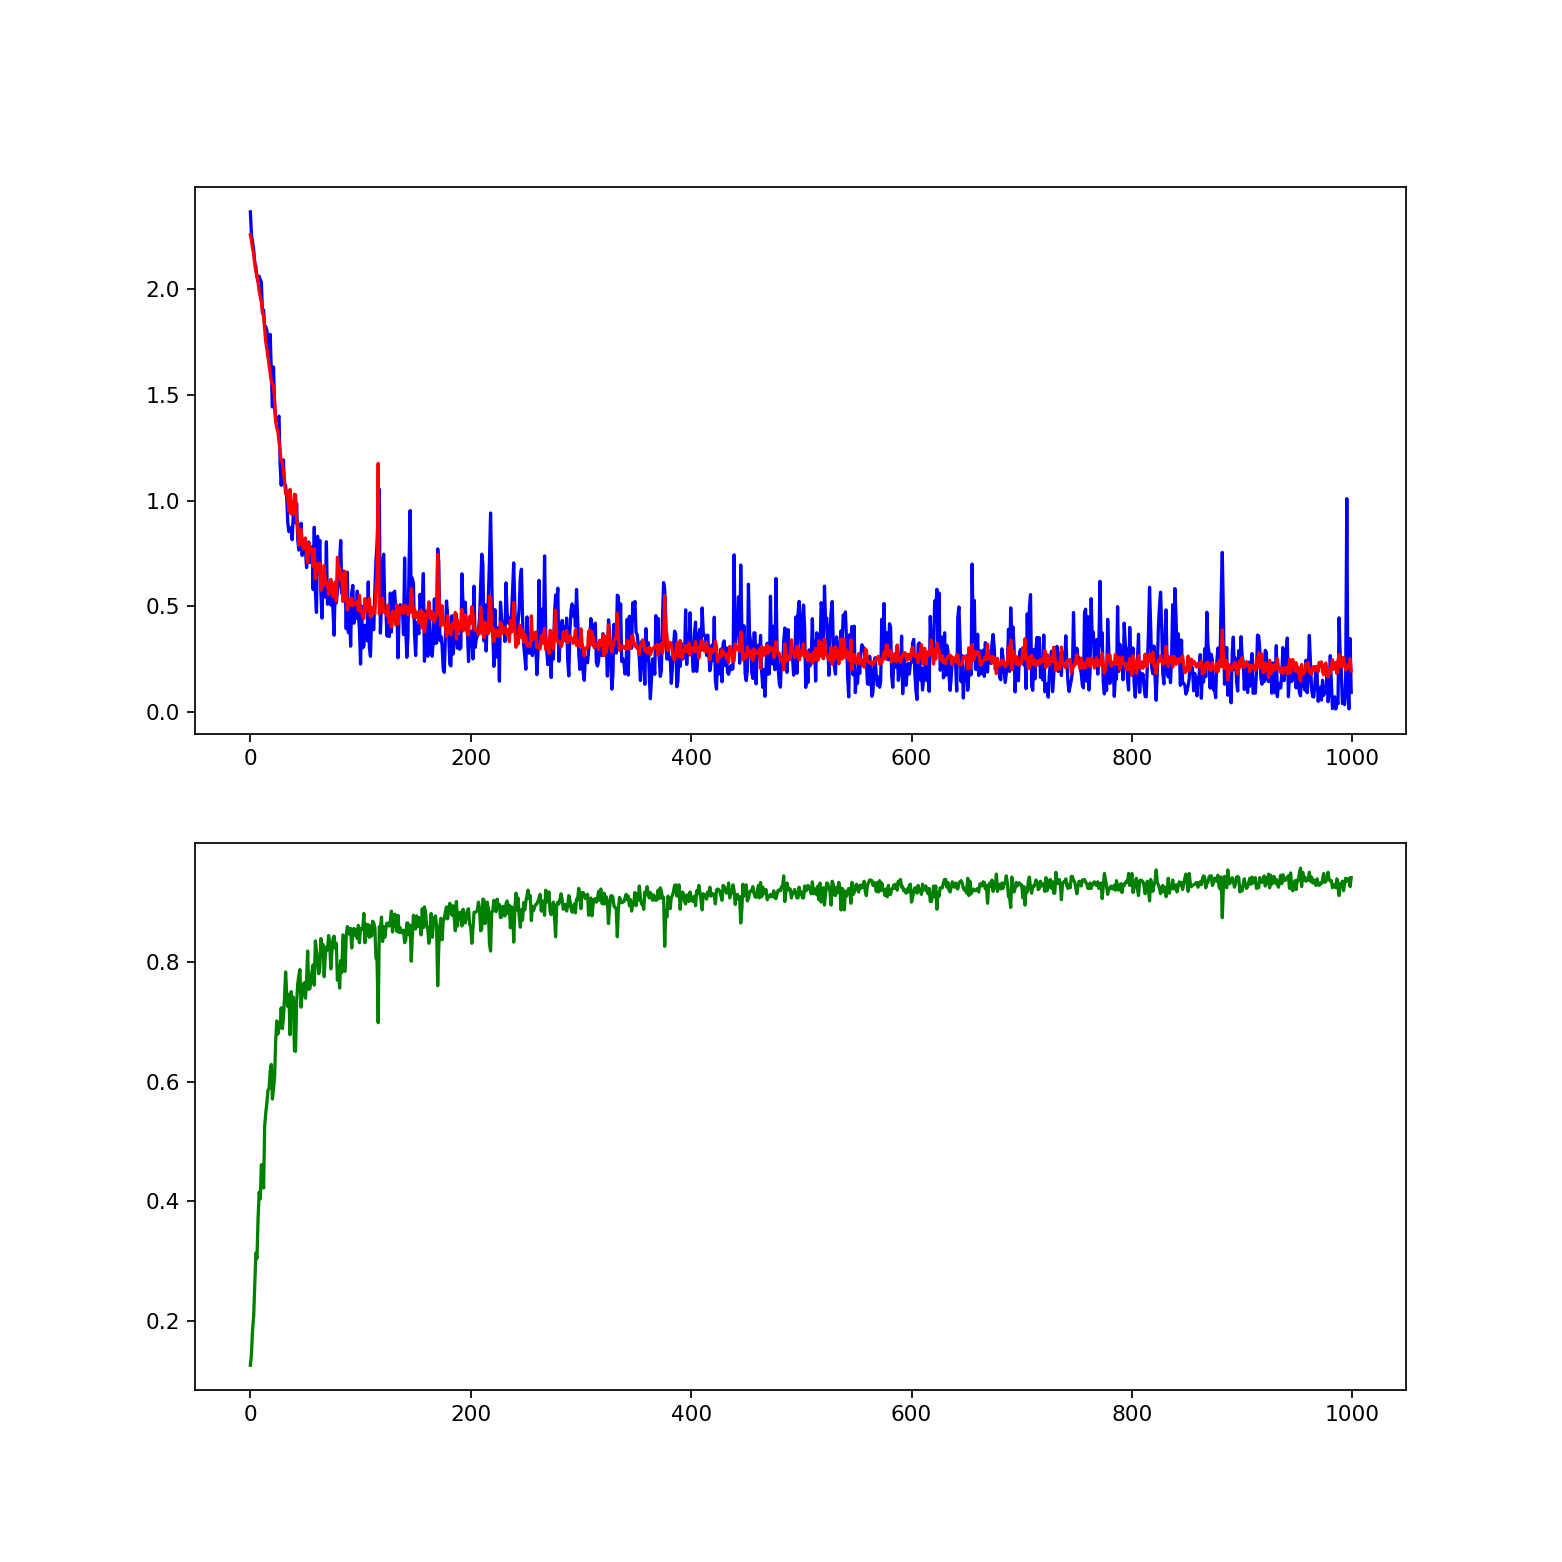

0.125
0.144
0.185
0.207
0.261
0.313
0.304
0.371
0.415
0.404
0.461
0.45
0.422
0.526
0.548
0.565
0.586
0.589
0.618
0.629
0.571
0.588
0.608
0.67
0.702
0.68
0.69
0.692
0.724
0.689
0.706
0.74
0.784
0.746
0.726
0.746
0.679
0.751
0.719
0.742
0.652
0.651
0.734
0.764
0.778
0.788
0.725
0.75
0.763
0.766
0.74
0.769
0.819
0.755
0.756
0.768
0.786
0.796
0.762
0.836
0.82
0.803
0.781
0.789
0.84
0.83
0.83
0.776
0.811
0.826
0.821
0.845
0.832
0.789
0.817
0.84
0.844
0.824
0.832
0.77
0.795
0.757
0.803
0.783
0.846
0.814
0.785
0.845
0.86
0.856
0.847
0.857
0.824
0.854
0.857
0.845
0.855
0.84
0.862
0.833
0.857
0.855
0.856
0.882
0.833
0.864
0.845
0.863
0.842
0.861
0.844
0.869
0.866
0.858
0.807
0.803
0.699
0.86
0.856
0.876
0.835
0.86
0.842
0.857
0.866
0.864
0.861
0.87
0.886
0.851
0.863
0.881
0.877
0.852
0.879
0.85
0.858
0.85
0.85
0.854
0.833
0.837
0.866
0.866
0.846
0.862
0.802
0.843
0.879
0.858
0.856
0.878
0.86
0.875
0.866
0.846
0.89
0.858
0.893
0.884
0.861
0.856
0.832
0.851
0.882
0.842
0.862
0.875
0.878
0.861
0.7

In [ ]:
xs = np.array_split(train_images, 1_000)
ys = np.array_split(train_labels_one_hot, 1_000)
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
for epoch in range(1, NUM_EPOCHS+1):
    for x, y in zip(xs, ys):
        y_, train_loss = nn.forward(x.reshape(-1, 28*28), y)
        nn.backward(y, y_)
        nn.gradient_descent_step(ALPHA)
        batch_images, batch_labels_one_hot = get_random_patch(test_images, test_labels_one_hot, 1000)
        y_, test_loss = nn.forward(batch_images.reshape(-1, 28*28), batch_labels_one_hot)
        acc = get_accuracy(batch_labels_one_hot, y_)
        print(acc)
        accuracies.append(acc)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        ax1.clear()
        ax2.clear()
        ax1.plot(train_losses, "b")
        ax1.plot(test_losses, "r")
        ax2.plot(accuracies, "g")
        fig.canvas.draw()